In [ ]:
import torch
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

try:
    import gpytorch
except:
    !pip install gpytorch
    import gpytorch

# settings for running on a specified Google Drive account.
from google.colab import drive
drive.mount('/content/gdrive')
gdrive_path = "/content/gdrive/MyDrive/"

root = 'Users/carlrichardson/Documents/Python/SEGP/'
dataset_number = 1

# Hardware settings.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print('Default tensor type is now cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
print("Device in use is: ", device)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Device in use is:  cpu


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Text(0.5, 1.0, 'y2')

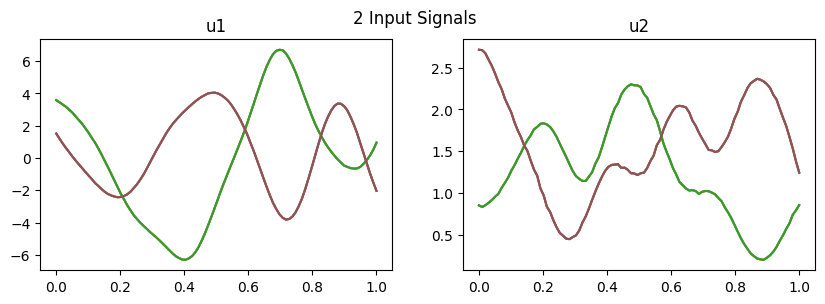

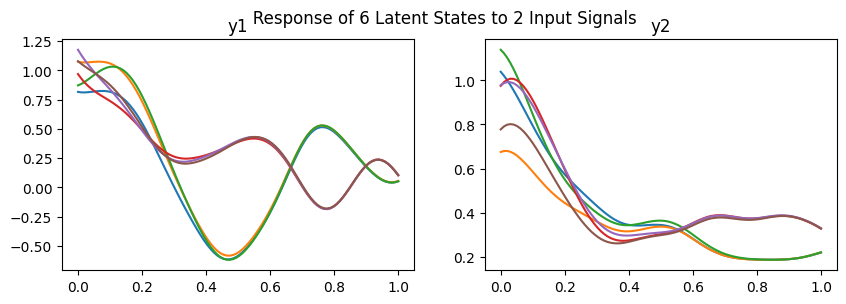

In [ ]:
# Settings for sampling M continuous input signals with K points on the interval (0,tmax).
# For each input signal, Q initial conditions are sampled leading to a dataset with M * Q
# p-dim input signals and m-dim latent state trajectories.

M = 100
Q = 100
tmax = 1.0
K = 100
m=2; n=4; p=2;
lt = 1e-1 # length scale of squared exponential kernel.

T = torch.linspace(0, tmax, K) # shape = (K)
step = T[1] - T[0]

# Define input signal GP and sample.
mean_U = torch.ones(K, p)
mean = gpytorch.means.MultitaskMean(gpytorch.means.ZeroMean(), num_tasks=p)
covar = gpytorch.kernels.MultitaskKernel(gpytorch.kernels.RBFKernel(), num_tasks=p, rank=1)
covar.data_covar_module.lengthscale = torch.tensor(lt)
mean.eval()
covar.eval()
U_GP = gpytorch.distributions.MultitaskMultivariateNormal( mean(T), covar(T) )

U = torch.zeros(M, Q, K, p)
for i in range(M):
  sample = U_GP.sample() # shape = (N, p)
  U[i] = sample.repeat(Q, 1, 1) # shape = (Q, N, p)
U = U + mean_U.repeat(M, Q, 1, 1)  # add non-zero mean, shape = (M, Q, 1, 1)



# Define LTI system.
A_sym = -5.*torch.eye(n)

A_skew = torch.tensor([[ 0.000,  0.059, -1.116,  1.384],
                       [-0.059,  0.000,  1.003, -0.033],
                       [ 1.116, -1.003,  0.000, -2.881],
                       [-1.384,  0.033,  2.881,  0.000]
                       ])

A = A_sym + 3*A_skew

B = 1.0 * torch.tensor([[1, 0],
                        [0, 1],
                        [0, 0],
                        [0, 0]
                       ])

C = 1.0 * torch.tensor([[1, 0, 0, 0],
                        [0, 1, 0, 0]])

D = 1e-1 * torch.tensor([[ 0.056,  0.099],
                         [ 0.034,  0.021]])

# Initial condition distribution parameters.
mean_x0 = torch.ones(n)
var_x0 = torch.tensor(5e-2)
covar_x0 = var_x0 * torch.eye(n)

# simulate dynamics.
X = []
Y = []
X0 = mean_x0.repeat(M, Q, 1) + torch.sqrt(var_x0) * torch.randn(M, Q, n)

Xi = torch.transpose(X0, 1, 2) # shape = (M, n, Q)
Yi = 1.0 * ( torch.matmul(C.repeat(M, 1, 1), Xi) # shape = (M, m, Q)
              + torch.matmul( D.repeat(M, 1, 1), torch.transpose(U[:,:,0,:], 1, 2) ) )
X.append( torch.transpose(Xi, 1, 2) )
Y.append( torch.transpose(Yi, 1, 2) )

for i in range(1, K):
  Xi = Xi + step * ( torch.matmul( A.repeat(M, 1, 1), Xi ) # shape = (M, n, Q)
                    + torch.matmul( B.repeat(M, 1, 1), torch.transpose(U[:,:,i,:], 1, 2)  ) )

  Yi = 1.0 * ( torch.matmul( C.repeat(M, 1, 1), Xi ) # shape = (M, m, Q)
                    + torch.matmul( D.repeat(M, 1, 1), torch.transpose( U[:,:,i,:], 1, 2) ) )

  X.append( torch.transpose(Xi, 1, 2) )
  Y.append( torch.transpose(Yi, 1, 2) )

X = torch.stack(X, dim=0) # (K, M, Q, n)
X = torch.transpose(X, 0, 1) # (M, K, Q, n)
X = torch.transpose(X, 1, 2) # (M, Q, K, n)

Y = torch.stack(Y, dim=0) # shape = (K, M, Q, m)
Y = torch.transpose(Y, 0, 1) # (M, K, Q, m)
Y = torch.transpose(Y, 1, 2) # (M, Q, K, m)

# plot randomly selected input signal and three randomly selected
# latent states in response to that trajectory.

rand_M = np.random.randint(0, M)
rand_Ms1 = np.random.randint(0, M-1)
rand_Q = np.random.randint(0, Q, 3)

# Plot sample of input signals and latent states.
fx, (u1_ax, u2_ax) = plt.subplots(1, 2, figsize=(10, 3))
u1_ax.plot(T.cpu().detach().numpy(), U[rand_M,rand_Q[0],:,0].cpu())
u2_ax.plot(T.cpu().detach().numpy(), U[rand_M,rand_Q[0],:,1].cpu())
u1_ax.plot(T.cpu().detach().numpy(), U[rand_M,rand_Q[1],:,0].cpu())
u2_ax.plot(T.cpu().detach().numpy(), U[rand_M,rand_Q[1],:,1].cpu())
u1_ax.plot(T.cpu().detach().numpy(), U[rand_M,rand_Q[2],:,0].cpu())
u2_ax.plot(T.cpu().detach().numpy(), U[rand_M,rand_Q[2],:,1].cpu())

u1_ax.plot(T.cpu().detach().numpy(), U[rand_Ms1,rand_Q[0],:,0].cpu())
u2_ax.plot(T.cpu().detach().numpy(), U[rand_Ms1,rand_Q[0],:,1].cpu())
u1_ax.plot(T.cpu().detach().numpy(), U[rand_Ms1,rand_Q[1],:,0].cpu())
u2_ax.plot(T.cpu().detach().numpy(), U[rand_Ms1,rand_Q[1],:,1].cpu())
u1_ax.plot(T.cpu().detach().numpy(), U[rand_Ms1,rand_Q[2],:,0].cpu())
u2_ax.plot(T.cpu().detach().numpy(), U[rand_Ms1,rand_Q[2],:,1].cpu())

fx.suptitle('2 Input Signals')
u1_ax.set_title('u1')
u2_ax.set_title('u2')

fy, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(10, 3))
y1_ax.plot(T.cpu().detach().numpy(), Y[rand_M,rand_Q[0],:,0].cpu())
y2_ax.plot(T.cpu().detach().numpy(), Y[rand_M,rand_Q[0],:,1].cpu())
y1_ax.plot(T.cpu().detach().numpy(), Y[rand_M,rand_Q[1],:,0].cpu())
y2_ax.plot(T.cpu().detach().numpy(), Y[rand_M,rand_Q[1],:,1].cpu())
y1_ax.plot(T.cpu().detach().numpy(), Y[rand_M,rand_Q[2],:,0].cpu())
y2_ax.plot(T.cpu().detach().numpy(), Y[rand_M,rand_Q[2],:,1].cpu())

y1_ax.plot(T.cpu().detach().numpy(), Y[rand_Ms1,rand_Q[0],:,0].cpu())
y2_ax.plot(T.cpu().detach().numpy(), Y[rand_Ms1,rand_Q[0],:,1].cpu())
y1_ax.plot(T.cpu().detach().numpy(), Y[rand_Ms1,rand_Q[1],:,0].cpu())
y2_ax.plot(T.cpu().detach().numpy(), Y[rand_Ms1,rand_Q[1],:,1].cpu())
y1_ax.plot(T.cpu().detach().numpy(), Y[rand_Ms1,rand_Q[2],:,0].cpu())
y2_ax.plot(T.cpu().detach().numpy(), Y[rand_Ms1,rand_Q[2],:,1].cpu())

fy.suptitle('   Response of 6 Latent States to 2 Input Signals')
y1_ax.set_title('y1')
y2_ax.set_title('y2')


Text(0.5, 1.0, 'y2')

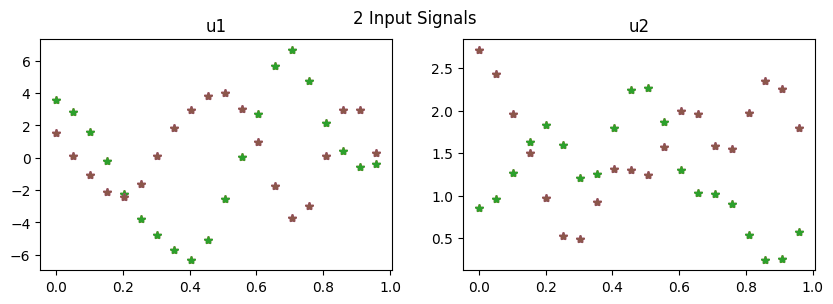

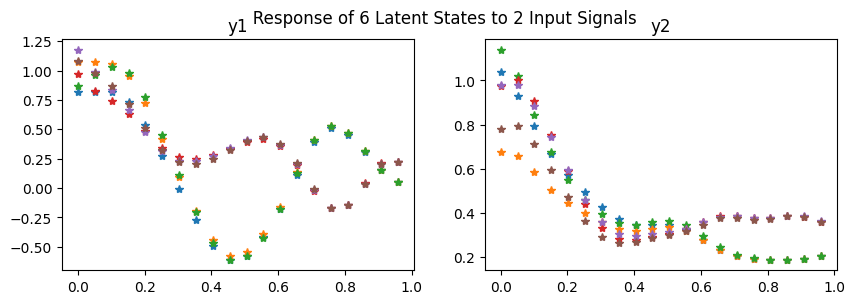

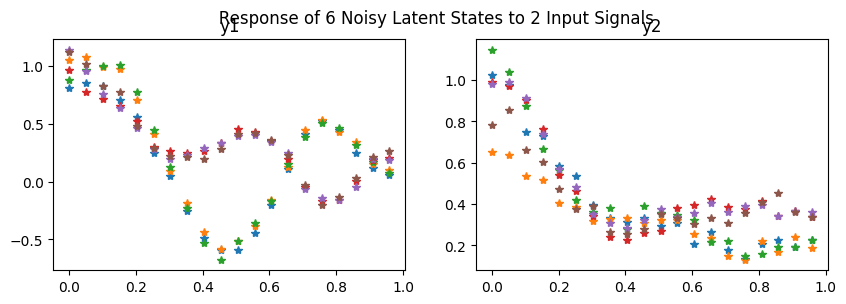

In [ ]:
# Settings for discretising signals.

Ts = 5 # sampling period is Ts * step

# discretising signals
dT = T[torch.remainder(torch.arange(T.shape[0]), Ts) == 0] # shape = (N)
dU = U[:, :, torch.remainder(torch.arange(U.shape[2]), Ts) == 0, :] # shape = (M, Q, N, p)
dY = Y[:, :, torch.remainder(torch.arange(Y.shape[2]), Ts) == 0, :] # shape = (M, Q, N, m)
mean_dU = mean_U[torch.remainder(torch.arange(mean_U.shape[0]), Ts) == 0, :] # shape = (N, p)
N = dY.shape[2] # number of discrete time points.

# add noise to discretised latent state.
var_noise = torch.tensor(1e-3)
covar_noise = var_noise * torch.eye(m*N)
dYn = dY + torch.sqrt(var_noise) * torch.randn(dY.shape) # shape = (M, Q, N, m)

# Plot sample of discretised input signals and latent states.
fx, (u1_ax, u2_ax) = plt.subplots(1, 2, figsize=(10, 3))
u1_ax.plot(dT.cpu(), dU[rand_M,rand_Q[0],:,0].cpu(), '*')
u2_ax.plot(dT.cpu(), dU[rand_M,rand_Q[0],:,1].cpu(), '*')
u1_ax.plot(dT.cpu(), dU[rand_M,rand_Q[1],:,0].cpu(), '*')
u2_ax.plot(dT.cpu(), dU[rand_M,rand_Q[1],:,1].cpu(), '*')
u1_ax.plot(dT.cpu(), dU[rand_M,rand_Q[2],:,0].cpu(), '*')
u2_ax.plot(dT.cpu(), dU[rand_M,rand_Q[2],:,1].cpu(), '*')

u1_ax.plot(dT.cpu(), dU[rand_Ms1,rand_Q[0],:,0].cpu(), '*')
u2_ax.plot(dT.cpu(), dU[rand_Ms1,rand_Q[0],:,1].cpu(), '*')
u1_ax.plot(dT.cpu(), dU[rand_Ms1,rand_Q[1],:,0].cpu(), '*')
u2_ax.plot(dT.cpu(), dU[rand_Ms1,rand_Q[1],:,1].cpu(), '*')
u1_ax.plot(dT.cpu(), dU[rand_Ms1,rand_Q[2],:,0].cpu(), '*')
u2_ax.plot(dT.cpu(), dU[rand_Ms1,rand_Q[2],:,1].cpu(), '*')

fx.suptitle('2 Input Signals')
u1_ax.set_title('u1')
u2_ax.set_title('u2')

fy, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(10, 3))
y1_ax.plot(dT.cpu(), dY[rand_M,rand_Q[0],:,0].cpu(), '*')
y2_ax.plot(dT.cpu(), dY[rand_M,rand_Q[0],:,1].cpu(), '*')
y1_ax.plot(dT.cpu(), dY[rand_M,rand_Q[1],:,0].cpu(), '*')
y2_ax.plot(dT.cpu(), dY[rand_M,rand_Q[1],:,1].cpu(), '*')
y1_ax.plot(dT.cpu(), dY[rand_M,rand_Q[2],:,0].cpu(), '*')
y2_ax.plot(dT.cpu(), dY[rand_M,rand_Q[2],:,1].cpu(), '*')

y1_ax.plot(dT.cpu(), dY[rand_Ms1,rand_Q[0],:,0].cpu(), '*')
y2_ax.plot(dT.cpu(), dY[rand_Ms1,rand_Q[0],:,1].cpu(), '*')
y1_ax.plot(dT.cpu(), dY[rand_Ms1,rand_Q[1],:,0].cpu(), '*')
y2_ax.plot(dT.cpu(), dY[rand_Ms1,rand_Q[1],:,1].cpu(), '*')
y1_ax.plot(dT.cpu(), dY[rand_Ms1,rand_Q[2],:,0].cpu(), '*')
y2_ax.plot(dT.cpu(), dY[rand_Ms1,rand_Q[2],:,1].cpu(), '*')

fy.suptitle('   Response of 6 Latent States to 2 Input Signals')
y1_ax.set_title('y1')
y2_ax.set_title('y2')

fy, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(10, 3))
y1_ax.plot(dT.cpu(), dYn[rand_M,rand_Q[0],:,0].cpu(), '*')
y2_ax.plot(dT.cpu(), dYn[rand_M,rand_Q[0],:,1].cpu(), '*')
y1_ax.plot(dT.cpu(), dYn[rand_M,rand_Q[1],:,0].cpu(), '*')
y2_ax.plot(dT.cpu(), dYn[rand_M,rand_Q[1],:,1].cpu(), '*')
y1_ax.plot(dT.cpu(), dYn[rand_M,rand_Q[2],:,0].cpu(), '*')
y2_ax.plot(dT.cpu(), dYn[rand_M,rand_Q[2],:,1].cpu(), '*')

y1_ax.plot(dT.cpu(), dYn[rand_Ms1,rand_Q[0],:,0].cpu(), '*')
y2_ax.plot(dT.cpu(), dYn[rand_Ms1,rand_Q[0],:,1].cpu(), '*')
y1_ax.plot(dT.cpu(), dYn[rand_Ms1,rand_Q[1],:,0].cpu(), '*')
y2_ax.plot(dT.cpu(), dYn[rand_Ms1,rand_Q[1],:,1].cpu(), '*')
y1_ax.plot(dT.cpu(), dYn[rand_Ms1,rand_Q[2],:,0].cpu(), '*')
y2_ax.plot(dT.cpu(), dYn[rand_Ms1,rand_Q[2],:,1].cpu(), '*')

fy.suptitle('   Response of 6 Noisy Latent States to 2 Input Signals')
y1_ax.set_title('y1')
y2_ax.set_title('y2')


In [ ]:
# Save data.
data_path = gdrive_path + root + 'Data/Datasets/GP/Dataset{0}'.format(dataset_number)

data_setup = {'M':M, 'Q':Q, 'tmax':tmax, 'K':K, 'm':m, 'n':n, 'p':p, 'lt':lt, 'step':step,
             'A':A, 'B':B, 'C':C, 'D':D, 'mean_x0':mean_x0, 'covar_x0':covar_x0,
             'Ts':Ts, 'N':N, 'covar_noise':covar_noise}

if os.path.isdir(data_path):
    raise Exception('Directory exists!')
else:
    os.makedirs(data_path)


with open(data_path + '/data_setup.pkl', 'wb') as f:
      pickle.dump(data_setup, f)
      f.close()

with open(data_path + '/mean_U.npy', 'wb') as f:
      np.save(f, mean_U.cpu().numpy())

with open(data_path + '/mean_dU.npy', 'wb') as f:
      np.save(f, mean_dU.cpu().numpy())

with open(data_path + '/T.npy', 'wb') as f:
      np.save(f, T.cpu().numpy())

with open(data_path + '/dT.npy', 'wb') as f:
      np.save(f, dT.cpu().numpy())

with open(data_path + '/dY.npy', 'wb') as f:
      np.save(f, dY.cpu().numpy())

with open(data_path + '/dYn.npy', 'wb') as f:
      np.save(f, dYn.cpu().numpy())
